In [1]:
import json, os, math, sys, re, random
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm, trange
from pprint import pprint
import matplotlib.pyplot as plt 
import matplotlib
import pandas as pd

In [2]:
task = "diffsymbol"

if task == "samesymbol":
    one = lambda: 'a'
elif task == "diffsymbol":
    one = lambda: random.choice('abcdefghijklmnopqrstuvwxyz')
else:
    pass

In [3]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [4]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        train_data.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:05<00:00, 194451.21it/s]


1000000 300


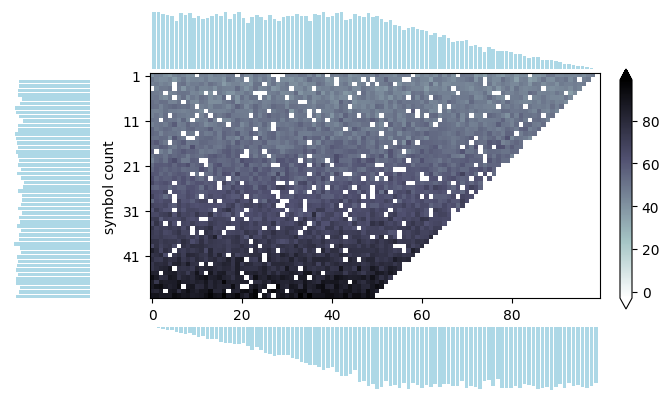

In [5]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

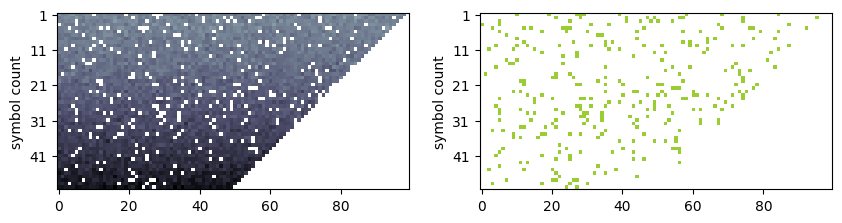

In [6]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [8]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [9]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [10]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1


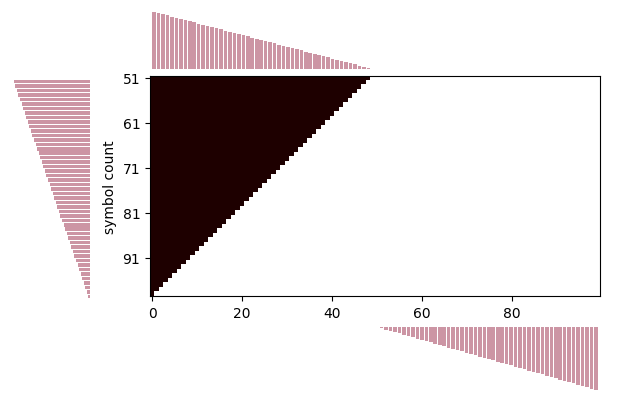

In [11]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()

In [12]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

In [13]:
list('445')

['4', '4', '5']